In [1]:
!ls

data_analysis_and _processing.ipynb


# Checkpoint Champion -- Predicting Winners at 25

**Name(s)**: Xingzhi Cui, Yun Jong Na

**Website Link**: https://mrtuge123.github.io/League_of_Legends_Analysis/

## Step 1: Introduction

Central Question: Can a classification model leverage in-game kills, gold, experience information at the 25 minute checkpoint to predict the game result?


In [109]:
# Loading Packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
pd.options.plotting.backend = 'plotly'

In [110]:
# Reading Data
dfs = []

file_path = f"/Users/kevinna/Desktop/EECS398/wn25/data/lol_2024.csv"
df = pd.read_csv(file_path, low_memory=False)
dfs.append(df)

data = pd.concat(dfs, ignore_index=True)


In [111]:
# Displaying Original Data Info
print("There are", df.shape[0], "rows and ", df.shape[1], "columns present in the data.")


There are 117600 rows and  161 columns present in the data.


In [112]:
# Number of Games Recorded
df['gameid'].nunique()

9800

In [113]:
#Columns in Data
columns = [x for x in data.columns]
columns

['gameid',
 'datacompleteness',
 'url',
 'league',
 'year',
 'split',
 'playoffs',
 'date',
 'game',
 'patch',
 'participantid',
 'side',
 'position',
 'playername',
 'playerid',
 'teamname',
 'teamid',
 'champion',
 'ban1',
 'ban2',
 'ban3',
 'ban4',
 'ban5',
 'pick1',
 'pick2',
 'pick3',
 'pick4',
 'pick5',
 'gamelength',
 'result',
 'kills',
 'deaths',
 'assists',
 'teamkills',
 'teamdeaths',
 'doublekills',
 'triplekills',
 'quadrakills',
 'pentakills',
 'firstblood',
 'firstbloodkill',
 'firstbloodassist',
 'firstbloodvictim',
 'team kpm',
 'ckpm',
 'firstdragon',
 'dragons',
 'opp_dragons',
 'elementaldrakes',
 'opp_elementaldrakes',
 'infernals',
 'mountains',
 'clouds',
 'oceans',
 'chemtechs',
 'hextechs',
 'dragons (type unknown)',
 'elders',
 'opp_elders',
 'firstherald',
 'heralds',
 'opp_heralds',
 'void_grubs',
 'opp_void_grubs',
 'firstbaron',
 'barons',
 'opp_barons',
 'firsttower',
 'towers',
 'opp_towers',
 'firstmidtower',
 'firsttothreetowers',
 'turretplates',
 'op

In [114]:
data.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
print("There are", data.shape[0], "rows and ", data.shape[1], "columns present in the data.")

There are 117600 rows and  161 columns present in the data.


## Step 2: Data Cleaning and Analysis

## Data Cleaning & Imputation

Data Cleaning: The original dataset includes both player-level and team-level statistics, with 12 rows per match. Since our prediction task focuses on overall team outcomes, we filtered the dataset to retain only the 2 team-level rows per game.

Imputation: A missing 25‑minute value indicates that the game state wasn’t recorded at that cut‑off, so these rows contain no usable mid‑game information. Imputing them would introduce unfounded assumptions, so we removed all records with missing 25‑minute features.



In [116]:
#Filter out team data
data = data[data['position'] == 'team']

In [117]:
# This is the filtered data with all the 2 team level rows.
print("There are", data.shape[0], "rows and ", data.shape[1], "columns present in the data. ")

There are 19600 rows and  161 columns present in the data. 


In [118]:
# Columns we selected relevant to 25 minute checkpoint, uncleaned
columns_to_check = [
    'goldat25', 'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25',
    'golddiffat25', 'xpdiffat25', 'csdiffat25',
    'killsat25', 'assistsat25', 'deathsat25',
    'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25'
]

In [119]:
# This showed that if one of the values is missing in the 25 minute checkpoint,
# all the other values are missing as well
data[columns_to_check].isna().mean()

goldat25           0.20102
xpat25             0.20102
csat25             0.20102
opp_goldat25       0.20102
opp_xpat25         0.20102
opp_csat25         0.20102
golddiffat25       0.20102
xpdiffat25         0.20102
csdiffat25         0.20102
killsat25          0.20102
assistsat25        0.20102
deathsat25         0.20102
opp_killsat25      0.20102
opp_assistsat25    0.20102
opp_deathsat25     0.20102
dtype: float64

In [120]:
# # Visualization of before and after dropping NaNs!
# # Create a copy of the data before dropping NaNs (if not already saved earlier)
# data_before_drop = data.copy()

# # Add source labels
# data_before_drop['source'] = 'Before Dropping Missing'
# data_after_drop = data_before_drop.dropna(subset=[
#     'goldat25', 'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25',
#     'golddiffat25', 'xpdiffat25', 'csdiffat25',
#     'killsat25', 'assistsat25', 'deathsat25',
#     'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25'
# ]).copy()
# data_after_drop['source'] = 'After Dropping Missing'

# # Combine and plot
# data_combined = pd.concat([data_before_drop, data_after_drop], axis=0)

# fig = px.histogram(
#     data_combined,
#     x='goldat25',
#     color='source',
#     barmode='overlay',
#     nbins=40,
#     title='Gold at 25 Minutes: Before vs After Dropping Missing Values',
#     labels={'goldat25': 'Gold at 25 Minutes'}
# )
# fig.update_layout(template='plotly_white')
# fig.show()
# Make a copy BEFORE dropping missing values
data_before_drop = data.copy()

# Define the columns used for 25-minute stats
columns_to_check = [
    'goldat25', 'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25',
    'golddiffat25', 'xpdiffat25', 'csdiffat25',
    'killsat25', 'assistsat25', 'deathsat25',
    'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25'
]

# Create cleaned version by dropping rows with missing 25-minute values
data_after_drop = data_before_drop.dropna(subset=columns_to_check).copy()


In [121]:
# Before and after dropping rows with missing values visualization

import plotly.graph_objects as go
# Count rows before, after, and how many were dropped
num_before = len(data_before_drop)
num_after = len(data_after_drop)
num_dropped = num_before - num_after

# Bar plot of row counts
fig = go.Figure(data=[
    go.Bar(name='Before Dropping Missing', x=['Row Count'], y=[num_before]),
    go.Bar(name='After Dropping Missing', x=['Row Count'], y=[num_after]),
    go.Bar(name='Dropped Rows', x=['Row Count'], y=[num_dropped])
])

fig.update_layout(
    title='Row Count Comparison Before and After Dropping Missing Values',
    yaxis_title='Number of Rows',
    barmode='group',
    template='plotly_white'
)

fig.write_html("row_count_comparison.html", include_plotlyjs='cdn')
fig.show()


In [122]:
# Because we need all these variables, and datapoints that 
# don't have one of these variables are likely to have missed all of them,
# we therefore simply dropped all the rows with missing values.

data = data.dropna(subset=columns_to_check)

In [123]:
print("There are", data.shape[0], "rows and ", data.shape[1], "columns present in the data. ")

There are 15660 rows and  161 columns present in the data. 


In [124]:
data_head_cols =  ['gameid', 'result'] + columns_to_check + ['side', 'gamelength','league']
print(data[data_head_cols].head().to_markdown(index=False))

| gameid           |   result |   goldat25 |   xpat25 |   csat25 |   opp_goldat25 |   opp_xpat25 |   opp_csat25 |   golddiffat25 |   xpdiffat25 |   csdiffat25 |   killsat25 |   assistsat25 |   deathsat25 |   opp_killsat25 |   opp_assistsat25 |   opp_deathsat25 | side   |   gamelength | league   |
|:-----------------|---------:|-----------:|---------:|---------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|------------:|--------------:|-------------:|----------------:|------------------:|-----------------:|:-------|-------------:|:---------|
| LOLTMNT99_132542 |        1 |      52523 |    58329 |      831 |          39782 |        47502 |          752 |          12741 |        10827 |           79 |          20 |            47 |            7 |               7 |                14 |               20 | Blue   |         1446 | TSC      |
| LOLTMNT99_132542 |        0 |      39782 |    47502 |      752 |          52523 |        58329 |        

#  Univariate Analysis

In [125]:
# Univariate Analysis
univariate_1 = px.histogram(
    data,
    x='goldat25',
    nbins=50,
    title='Distribution of Team Gold at 25 Minutes',
    labels={'goldat25': 'Gold at 25 Minutes'}
)

univariate_1.update_layout(
    template='plotly_white',
    bargap=0.05,
    xaxis_title='Total Gold',
    yaxis_title='Number of Teams',
    showlegend=False
)
univariate_1.show()

In [126]:
univariate_2 = px.histogram(data, x='golddiffat25', nbins=50, title='Distribution of Gold Difference at 25 Minutes')
univariate_2.update_layout(
    template='plotly_white',
    bargap=0.05,
    xaxis_title='Gold Difference at 25 Minutes',
    yaxis_title='Number of Teams',
    showlegend=False
)
univariate_2.show()


#  Bivariate Analysis

In [127]:
# Bivariate Analysis

bivariate_1 = px.box(
    data,
    x='result',
    y='goldat25',
    points='all',
    title='Team Gold at 25 Minutes by Match Outcome',
    labels={'result': 'Match Result', 'goldat25': 'Gold at 25 Minutes'}
)

bivariate_1.update_xaxes(tickvals=[0, 1], ticktext=['Loss', 'Win'])
bivariate_1.update_layout(template='plotly_white')
# bivariate_1.write_html("goldat25_by_result.html", include_plotlyjs='cdn')
bivariate_1.show()

In [128]:
bivariate_2 = px.box(
    data,
    x='result',
    y='killsat25',
    points='all',
    title='Team Kills at 25 Minutes by Match Outcome',
    labels={'result': 'Match Result', 'killsat25': 'Kills at 25 Minutes'}
)

bivariate_2.update_xaxes(tickvals=[0, 1], ticktext=['Loss', 'Win'])
bivariate_2.update_layout(template='plotly_white')
# fig.write_html("killsat25_by_result.html", include_plotlyjs='cdn')
bivariate_2.show()

In [129]:
bivariate_3 = px.scatter(
    data,
    x='goldat25', y='killsat25',
    color='result',
    title='Gold vs Kills at 25 Minutes, Colored by Match Result',
    labels={'goldat25': 'Gold', 'killsat25': 'Kills', 'result': 'Win (1) or Loss (0)'}
)

bivariate_3.update_layout(template='plotly_white')
# bivariate_3.write_html("gold_vs_kills_by_result.html", include_plotlyjs='cdn')
bivariate_3.show()

#  Interesting Aggregates

In [130]:
import plotly.graph_objects as go

summary = data.groupby('result')[[
    'goldat25', 'xpat25', 'csat25', 'killsat25', 'deathsat25'
]].mean().round(2).reset_index()

aggregate_table = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary.columns),
        fill_color='lightblue',
        align='center',
        font=dict(color='black', size=14)
    ),
    cells=dict(
        values=[summary[col] for col in summary.columns],
        fill_color='lavender',
        align='center',
        font=dict(color='black', size=12)
    ))
])
aggregate_table.show()

## Step 3: Framing a Prediction Problem


We frame our task as a binary classification problem:

Target Variable: result, where

    1 = the team won the match

    0 = the team lost the match

Features: All features available at the 25-minute mark, after data filtering and cleaning (see previous section). These include:

    goldat25, xpat25, csat25, killsat25, deathsat25

    Opponent metrics (e.g., opp_goldat25, opp_xpat25, ...)

We explicitly exclude any features not observable at 25 minutes (e.g., final score, dragons, towers, or match winner).

## Step 4: Baseline Model Construction

In [131]:
# Columns for Baseline Model
columns_to_check = [
    'goldat25', 'xpat25', 'csat25', 'killsat25','deathsat25'
]


In [132]:
# Splitting into training and testing sets:
cols = ['gameid']+['result'] + columns_to_check
mod_data = data.copy()
data_part1 = mod_data[cols]
y = data_part1['result']
X = data_part1[columns_to_check]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=103) 


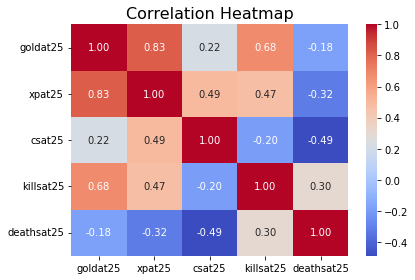

In [133]:
# Show that the data still has lingering multicorrelations
corr_matrix = X.corr()

# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [134]:
#Baseline model, simple logistic regression
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=398, solver='liblinear') 
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)

log_reg_cv = pipeline.named_steps['logisticregression']
num_non_zero = np.count_nonzero(log_reg_cv.coef_[0])
roc_auc = roc_auc_score(y_test, pipeline.decision_function(X_test))

y_train_pred = pipeline.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)

new_row = {
    'Model Name': 'Baseline_Simple_Logistic_Regression',
    'num_non_zero': num_non_zero,
    'training_accuracy': training_accuracy,
    'testing_accuracy': testing_accuracy,
    'ROC_accuracy': roc_auc
}

row_df = pd.DataFrame([new_row])

# Initializes output DataFrame
Model_selection_df = pd.DataFrame([new_row], columns = ['Model Name','num_non_zero',
                                             'training_accuracy','testing_accuracy','ROC_accuracy'])

print(Model_selection_df.to_markdown(index=False))


| Model Name                          |   num_non_zero |   training_accuracy |   testing_accuracy |   ROC_accuracy |
|:------------------------------------|---------------:|--------------------:|-------------------:|---------------:|
| Baseline_Simple_Logistic_Regression |              5 |            0.809433 |           0.812473 |       0.897624 |


## Step 5: Final Model & Attempting Better Models

In [135]:
# Filtering data and columns for future models
data['side_binary'] = data['side'].map({'Blue': 0, 'Red': 1})
cols = ['gameid','result','goldat25', 'xpat25', 'csat25', 'killsat25','deathsat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'side_binary' ,'gamelength', 'league']
data = data[cols]
y = data['result']
X = data[['goldat25', 'xpat25', 'csat25', 'killsat25','deathsat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'side_binary' ,'gamelength', 'league']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=103) 

In [136]:
# Define a data preprocessor
numeric_feats = ['goldat25', 'xpat25', 'csat25', 'killsat25','deathsat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'side_binary' ,'gamelength']
categorical_feats = ['league']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feats)
], remainder='drop') 

In [137]:
# LASSO
pipeline = make_pipeline(
    preprocessor,
    LogisticRegressionCV(
        cv=5,
        penalty='l1',
        solver='liblinear',
        random_state=398
    )
)

pipeline.fit(X_train, y_train)

ct = pipeline.named_steps['columntransformer']
feature_names = ct.get_feature_names_out()

y_test_pred = pipeline.predict(X_test)
y_test_score = pipeline.decision_function(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc          = roc_auc_score(y_test, y_test_score)

log_reg_cv = pipeline.named_steps['logisticregressioncv']

coef_series = pd.Series(
    log_reg_cv.coef_[0],
    index=feature_names
)

selected_features = coef_series[coef_series != 0].index.tolist()
num_non_zero = len(selected_features)

y_train_pred = pipeline.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)

new_row = {
    'Model Name':        'LogisticRegressionCV_L1',
    'num_non_zero':      num_non_zero,
    'training_accuracy': training_accuracy,
    'testing_accuracy':  testing_accuracy,
    'ROC_accuracy':      roc_auc
}

Model_selection_df.loc[len(Model_selection_df)] = new_row

In [138]:
import plotly.graph_objects as go
import pandas as pd

# Assuming nonzero_coefs is already defined
nonzero_coefs = coef_series[coef_series != 0].sort_values(key=abs, ascending=False)
nonzero_coefs_sorted = nonzero_coefs.sort_values(key=abs, ascending=True).copy()

# Classify each feature for color-coding: team, opponent, or other
def classify_feature(name):
    if 'opp_' in name:
        return 'Opponent'
    elif 'side' in name or 'gamelength' in name:
        return 'Other'
    else:
        return 'Team'

feature_type = [classify_feature(name) for name in nonzero_coefs_sorted.index]
feature_colors = {
    'Team': 'cornflowerblue',
    'Opponent': 'salmon',
    'Other': 'gray'
}
colors = [feature_colors[ftype] for ftype in feature_type]

# Create hover text
hover_text = [
    f"<b>{feat}</b><br>Effect: {'↑ Win chance' if val > 0 else '↓ Win chance'}<br>Coefficient: {val:.4f}<br>Source: {ftype}"
    for feat, val, ftype in zip(nonzero_coefs_sorted.index, nonzero_coefs_sorted.values, feature_type)
]

# Build Plotly Figure
fig = go.Figure(go.Bar(
    x=nonzero_coefs_sorted.values,
    y=nonzero_coefs_sorted.index,
    orientation='h',
    marker_color=colors,
    hovertext=hover_text,
    hoverinfo="text",
))

fig.update_layout(
    title='LASSO Feature Importance with Team vs Opponent Coloring',
    xaxis_title='Coefficient Value',
    yaxis_title='Feature',
    template='plotly_white',
    margin=dict(l=140, r=40, t=60, b=40),
    height=600
)

# Save for iframe embedding
# fig.write_html("lasso_feature_importance_explained.html", include_plotlyjs='cdn')

# Show inline if desired
fig.show()


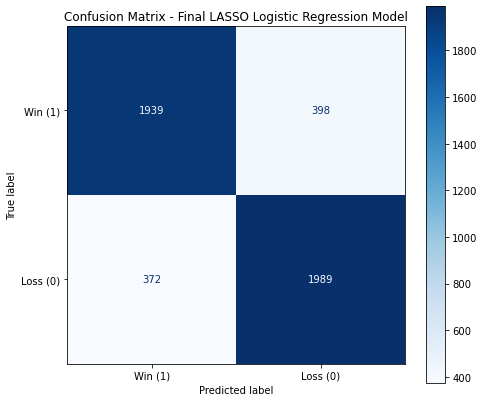

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Win (1)', 'Loss (0)'])

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Final LASSO Logistic Regression Model")
plt.tight_layout()
plt.savefig("confusion_matrix_final_model.png")  # Optional: for website
plt.show()

In [ ]:
#Ridge_Logistic_Regression
pipeline_ridge = make_pipeline(
    preprocessor,  
    LogisticRegressionCV(
        cv=5,
        penalty='l2',
        solver='liblinear',
        random_state=398
    )
)

pipeline_ridge.fit(X_train, y_train)

y_pred_ridge        = pipeline_ridge.predict(X_test)
testing_accuracy_ridge  = accuracy_score(y_test, y_pred_ridge)
y_train_pred_ridge      = pipeline_ridge.predict(X_train)
training_accuracy_ridge = accuracy_score(y_train, y_train_pred_ridge)
roc_auc_ridge           = roc_auc_score(
    y_test,
    pipeline_ridge.decision_function(X_test)
)

ridge_model      = pipeline_ridge.named_steps['logisticregressioncv']
feature_names    = pipeline_ridge.named_steps['columntransformer'] \
                                 .get_feature_names_out()
coef_series_ridge = pd.Series(
    ridge_model.coef_[0],
    index=feature_names
)
num_non_zero_ridge = (coef_series_ridge != 0).sum()


Model_selection_df.loc[len(Model_selection_df)] = {
    'Model Name':        'Ridge_LogisticRegressionCV',
    'num_non_zero':      num_non_zero_ridge,
    'training_accuracy': training_accuracy_ridge,
    'testing_accuracy':  testing_accuracy_ridge,
    'ROC_accuracy':      roc_auc_ridge
}

print(Model_selection_df.to_markdown(index=False))

| Model Name                          |   num_non_zero |   training_accuracy |   testing_accuracy |   ROC_accuracy |
|:------------------------------------|---------------:|--------------------:|-------------------:|---------------:|
| Baseline_Simple_Logistic_Regression |              5 |            0.809433 |           0.812473 |       0.897624 |
| LogisticRegressionCV_L1             |              9 |            0.835888 |           0.8361   |       0.921376 |
| Ridge_LogisticRegressionCV          |             57 |            0.835979 |           0.836526 |       0.921788 |


In [ ]:
# Backwards elimination to find the best function
base_model = LogisticRegression(solver='liblinear', penalty='l1', random_state=398)

pipeline_rfecv = make_pipeline(
    preprocessor,  # ColumnTransformer defined earlier
    RFECV(
        estimator=base_model,
        cv=5,
        scoring='roc_auc',
        step=1
    )
)

pipeline_rfecv.fit(X_train, y_train)

y_pred_rfecv         = pipeline_rfecv.predict(X_test)
testing_accuracy_rfecv  = accuracy_score(y_test, y_pred_rfecv)
roc_auc_rfecv           = roc_auc_score(y_test, pipeline_rfecv.decision_function(X_test))

y_train_pred_rfecv      = pipeline_rfecv.predict(X_train)
training_accuracy_rfecv = accuracy_score(y_train, y_train_pred_rfecv)

feature_names   = pipeline_rfecv.named_steps['columntransformer'].get_feature_names_out()
rfecv_step      = pipeline_rfecv.named_steps['rfecv']
support_mask    = rfecv_step.support_
selected_features = feature_names[support_mask].tolist()

coef_selected = pd.Series(rfecv_step.estimator_.coef_[0], index=selected_features)
num_non_zero_rfecv = np.count_nonzero(coef_selected)

Model_selection_df.loc[len(Model_selection_df)] = {
    'Model Name':        'LogisticRegression_RFECV_BackwardElimination',
    'num_non_zero':      num_non_zero_rfecv,
    'training_accuracy': training_accuracy_rfecv,
    'testing_accuracy':  testing_accuracy_rfecv,
    'ROC_accuracy':      roc_auc_rfecv
}

print(Model_selection_df.to_markdown(index=False))

| Model Name                                   |   num_non_zero |   training_accuracy |   testing_accuracy |   ROC_accuracy |
|:---------------------------------------------|---------------:|--------------------:|-------------------:|---------------:|
| Baseline_Simple_Logistic_Regression          |              5 |            0.809433 |           0.812473 |       0.897624 |
| LogisticRegressionCV_L1                      |              9 |            0.835888 |           0.8361   |       0.921376 |
| Ridge_LogisticRegressionCV                   |             57 |            0.835979 |           0.836526 |       0.921788 |
| LogisticRegression_RFECV_BackwardElimination |              5 |            0.835523 |           0.833972 |       0.920703 |


## Conclusion: Based on the above table, we chose the LASSO regression (L1 regularization)